In [ ]:
!pip install keras-tuner shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, RepeatVector, Bidirectional
from kerastuner import RandomSearch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import shap
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

<ipython-input-5-f228eb81a442>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [ ]:
# Load data
df = pd.read_csv('/content/sample_data/energydata_complete.csv')

In [ ]:
#First few rows
display(df.head())

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
# Summary statistics
display(df.describe())

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [ ]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64


In [ ]:
df2 = df.copy()

In [ ]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

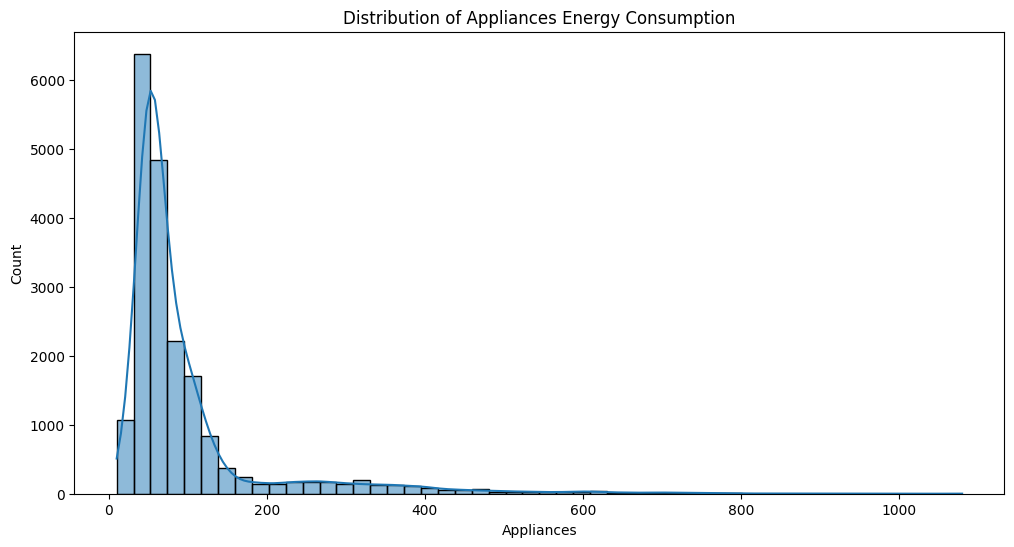

In [ ]:
# Check data distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Appliances'], bins=50, kde=True)
plt.title("Distribution of Appliances Energy Consumption")
plt.show()

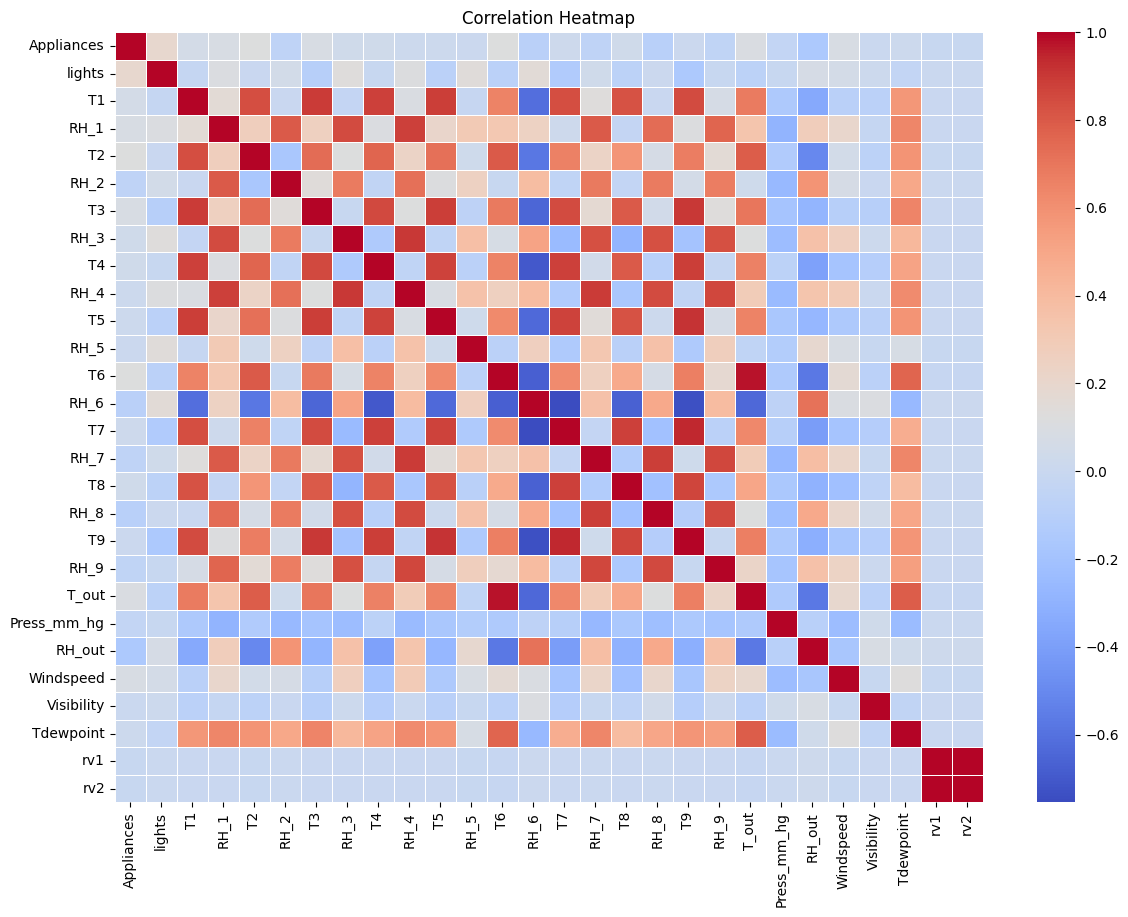

In [ ]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

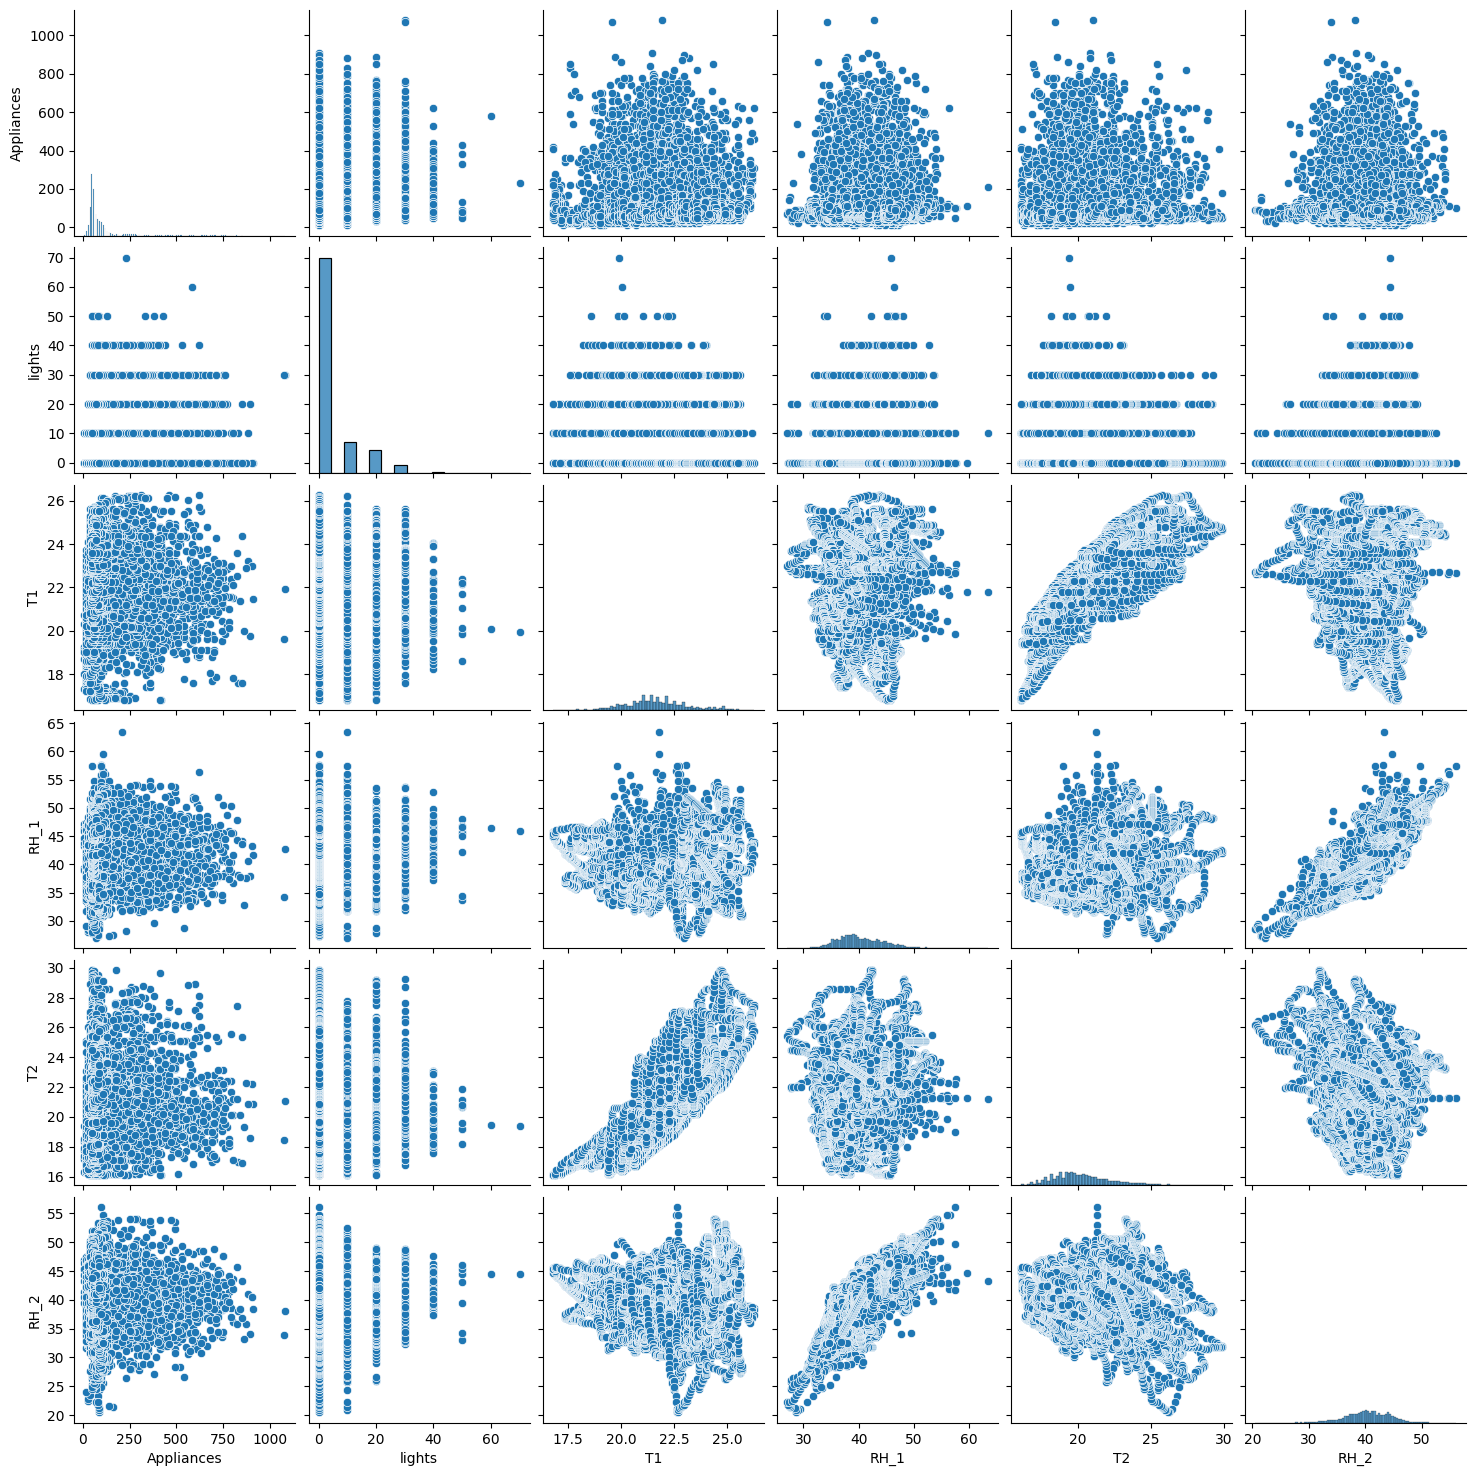

In [ ]:
# Pairplot for selected features
selected_features = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2']
sns.pairplot(df[selected_features])
plt.show()

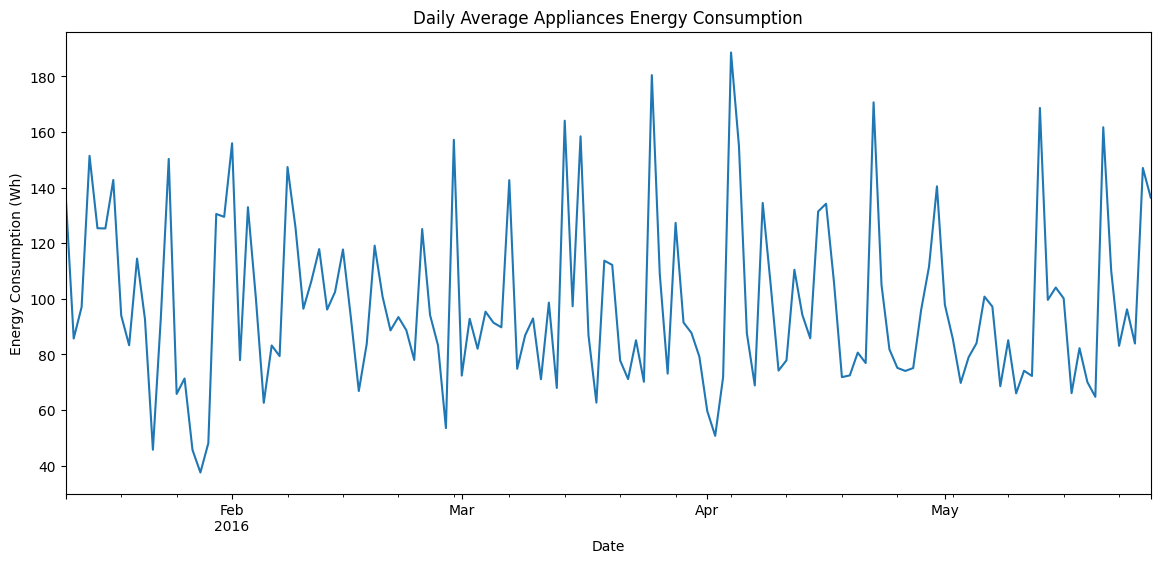

In [ ]:
# Time series analysis
plt.figure(figsize=(14, 6))
df['Appliances'].resample('D').mean().plot()
plt.title("Daily Average Appliances Energy Consumption")
plt.ylabel("Energy Consumption (Wh)")
plt.xlabel("Date")
plt.show()

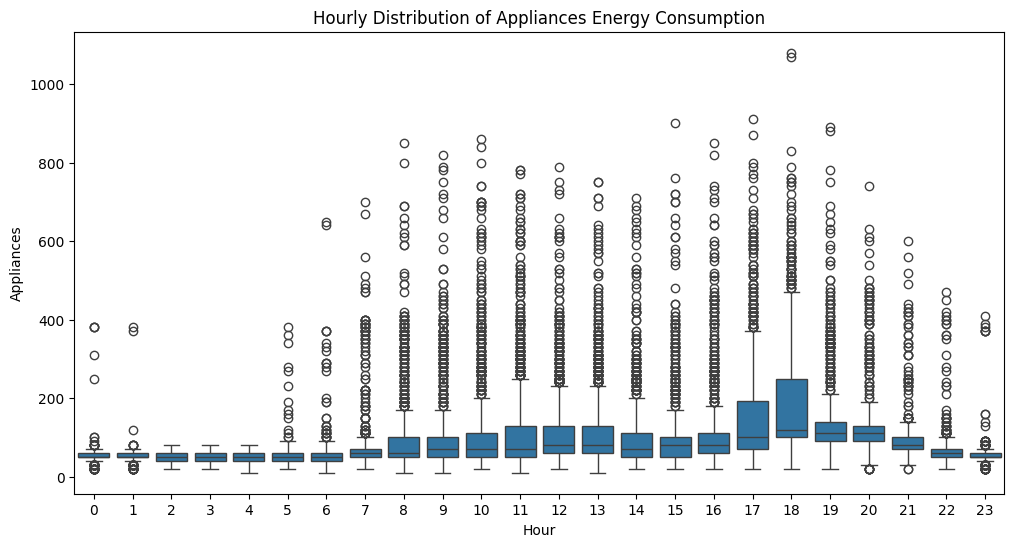

In [ ]:
# Boxplot of energy consumption by hour
df['Hour'] = df.index.hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='Appliances', data=df)
plt.title("Hourly Distribution of Appliances Energy Consumption")
plt.show()

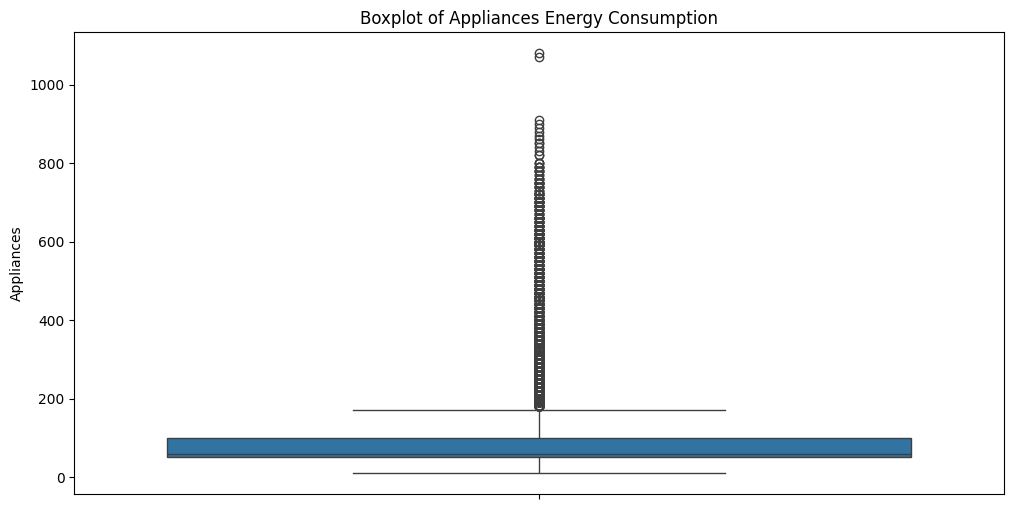

In [ ]:
# Outlier detection
plt.figure(figsize=(12, 6))
sns.boxplot(y=df['Appliances'])
plt.title("Boxplot of Appliances Energy Consumption")
plt.show()

In [ ]:
# Feature correlation with target variable
corr_with_target = df.corr()['Appliances'].sort_values(ascending=False)
print("Top correlated features with Appliances:\n", corr_with_target.head(10))

Top correlated features with Appliances:
 Appliances    1.000000
Hour          0.216792
lights        0.197278
T2            0.120073
T6            0.117638
T_out         0.099155
Windspeed     0.087122
RH_1          0.086031
T3            0.085060
T1            0.055447
Name: Appliances, dtype: float64


In [ ]:
#Preprocessing

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [ ]:
# Feature engineering
df2['date'] = pd.to_datetime(df2['date'])
df2['hour'] = df2['date'].dt.hour
df2['weekday'] = df2['date'].dt.weekday
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day
df2['hour_sin'] = np.sin(2 * np.pi * df2['hour'] / 24)
df2['hour_cos'] = np.cos(2 * np.pi * df2['hour'] / 24)

In [ ]:
# Rolling statistics (4-hour window)
df2['T_out_rolling'] = df2['T_out'].rolling(window=24).mean()
df2['RH_out_rolling'] = df2['RH_out'].rolling(window=24).mean()

In [ ]:
df2.dropna(inplace=True)

In [ ]:
# Selecting relevant features
features = df2.drop(columns=['Appliances', 'date'])
y = df2['Appliances']

In [ ]:
features.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,rv1,rv2,hour,weekday,month,day,hour_sin,hour_cos,T_out_rolling,RH_out_rolling
23,40,21.100000,46.596667,20.356667,44.963333,20.29,46.633333,19.39,48.426667,17.566667,...,6.277755,6.277755,20,0,1,11,-0.866025,0.500000,6.062500,90.229167
24,30,21.133333,46.060000,20.426667,44.760000,20.29,46.433333,19.39,48.193333,17.760000,...,13.361033,13.361033,21,0,1,11,-0.707107,0.707107,6.037500,90.020833
25,20,21.200000,45.800000,20.500000,44.760000,20.39,46.223333,19.39,47.800000,18.356667,...,19.305705,19.305705,21,0,1,11,-0.707107,0.707107,6.014583,89.819444
26,30,21.290000,45.900000,20.533333,45.090000,20.39,46.090000,19.39,47.560000,18.356667,...,0.669517,0.669517,21,0,1,11,-0.707107,0.707107,5.993750,89.625000
27,20,21.356667,45.826667,20.666667,45.163333,20.39,46.090000,19.39,47.500000,18.600000,...,19.119398,19.119398,21,0,1,11,-0.707107,0.707107,5.975000,89.437500


In [ ]:
features.isna().sum()

,0
lights,0
T1,0
RH_1,0
T2,0
RH_2,0
T3,0
RH_3,0
T4,0
RH_4,0
T5,0


In [ ]:
# MinMax Scaler
scaler = MinMaxScaler()
#scaler_y = MinMaxScaler()

In [ ]:
#Normalizing the feature set
X = scaler.fit_transform(features)

In [ ]:
#y_scaled  = scaler_y.fit_transform(label.values.reshape(-1, 1))

In [ ]:
print(np.min(X), np.max(X))
#print(np.min(y_scaled), np.max(y_scaled))

0.0 1.0000000000000002


In [ ]:
# Create sequences for LSTM/CNN
def create_sequences(X, y, window_size=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
#Creating the sequences
X_seq, y_seq = create_sequences(X, y, window_size=24)

In [ ]:
# Splitting the data using time-based approach
split_index = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

In [ ]:
#Inverse transform y_test
#y_test = scaler_y.inverse_transform(y_test_scaled)

Functions to Visualize Models Performances

In [ ]:
#Learning Curve
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'{model_name} - Training vs. Validation Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'{model_name} - Training vs. Validation MAE')
    plt.legend()

    plt.show()


#Scatter plot of actual y vs predicted y
def plot_scatter_actual_vs_predicted(y_test, y_pred, x_label, y_label, model_name):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
    plt.xlabel(f'{x_label}')
    plt.ylabel(f'{y_label}')
    plt.title(f'{model_name} - {y_label} vs. {x_label}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linestyle='dashed')
    plt.show()



#Residuals plot
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred.flatten()
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True, bins=30, color='red')
    plt.xlabel("Residuals (Error)")
    plt.ylabel("Frequency")
    plt.title(f'{model_name} - Residuals Distribution')
    plt.show()




LSTM MODEL

In [ ]:
#Function for the LSTM MODEL
def build_lstm_model(hp, input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units_1', 64, 128, step=32), return_sequences=True),
                            input_shape=input_shape))
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.3)))

    model.add(LSTM(units=hp.Int('units_2', 32, 64, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.3)))

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 5e-4])), loss='mse', metrics=['mae'])

    return model

In [ ]:
#Hyperparameter tunning using RandomSearch the LSTM
lstm_tuner = RandomSearch(
    lambda hp: build_lstm_model(hp, input_shape=(X_train.shape[1], X_train.shape[2])),
    objective='val_mae',
    max_trials=3,
    directory='tuning1',
    project_name='energy_lstm',
    overwrite=True )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#For early stops
#callbacks = [EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True),
          #   ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5)]

In [ ]:
#Performing the hyperparameter tuning
lstm_tuner.search(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

Trial 3 Complete [00h 13m 19s]
val_mae: 39.294166564941406

Best val_mae So Far: 37.293025970458984
Total elapsed time: 00h 32m 19s


In [ ]:
#Selecting the best LSTM parameter
best_lstm = lstm_tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Training the best LSTM model
lstm_history = best_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - loss: 7078.7358 - mae: 43.8050 - val_loss: 6757.6772 - val_mae: 37.4977
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 6708.4077 - mae: 42.8500 - val_loss: 6760.0698 - val_mae: 36.4441
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - loss: 6544.1118 - mae: 42.0546 - val_loss: 6498.9307 - val_mae: 38.7213
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 6591.5869 - mae: 42.0233 - val_loss: 6574.9062 - val_mae: 40.4392
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 6333.8794 - mae: 41.8793 - val_loss: 7253.8691 - val_mae: 36.4493
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 7012.8735 - mae: 43.3750 - val_loss: 6378.3989 - val_mae: 39.0284
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 6466.0200 - mae: 42.1686 - val_loss: 6263.1333 - val_mae: 38.1711
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 6940.2661 - mae: 43.0491 - val_loss: 6675.

In [ ]:
#Predictions for LSTM model
y_pred_lstm = best_lstm.predict(X_test)

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [ ]:
#Inverse transform predictions
#y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)

In [ ]:
#Inverse transform y_test
y_test1 = y_test
#scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

In [ ]:
#LSTM Evaluations
lstm_mae = mean_absolute_error(y_test1, y_pred_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test1, y_pred_lstm))
lstm_r2 = r2_score(y_test1, y_pred_lstm)
lstm_accuracy = 1 - (lstm_mae / np.mean(y_test1))

In [ ]:
print(f"LSTM MAE: {lstm_mae:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM R²: {lstm_r2:.4f}")
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

LSTM MAE: 65.8721
LSTM RMSE: 104.9994
LSTM R²: -0.3356
LSTM Accuracy: 0.3144


In [ ]:
#Ressiduals
lstm_ress = y_test1 - y_pred_lstm.flatten()

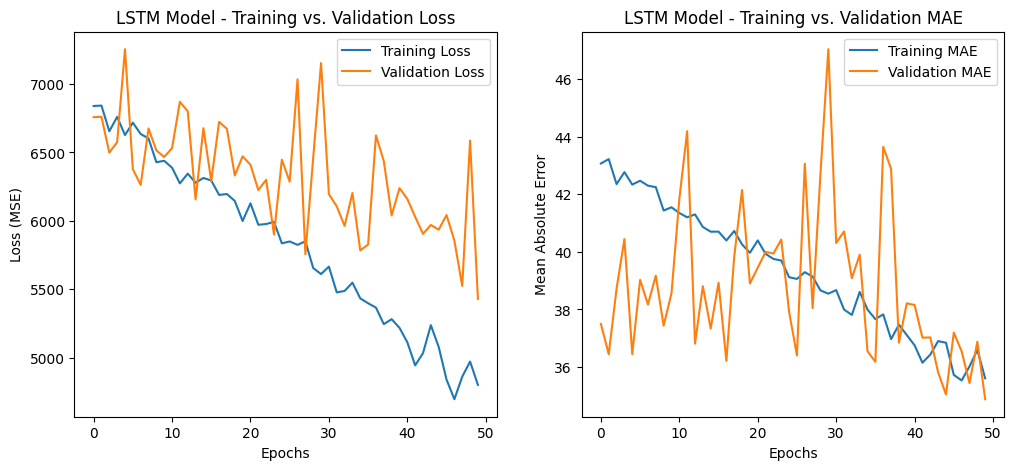

In [ ]:
#LSTM learning curves
plot_training_history(lstm_history, 'LSTM Model')

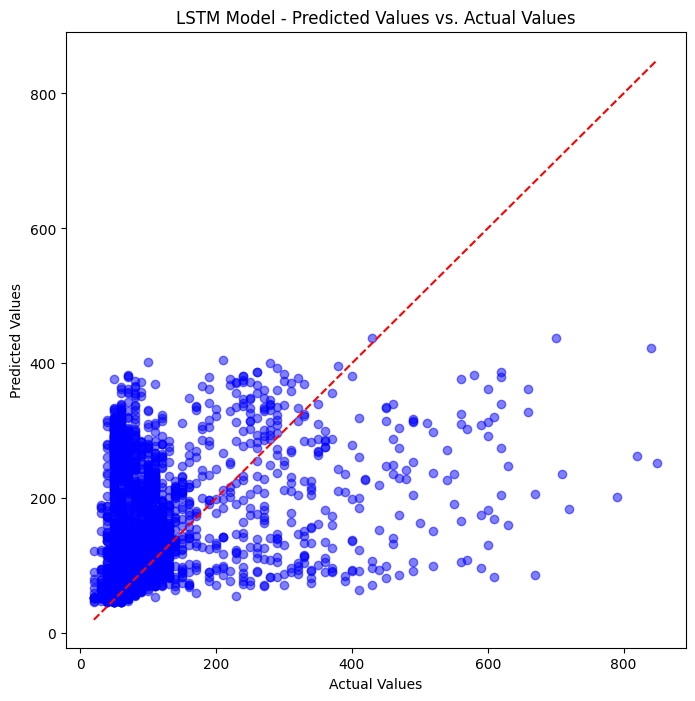

In [ ]:
#LSTM Scatter plot
plot_scatter_actual_vs_predicted(y_test1, y_pred_lstm, 'Actual Values', 'Predicted Values', 'LSTM Model')

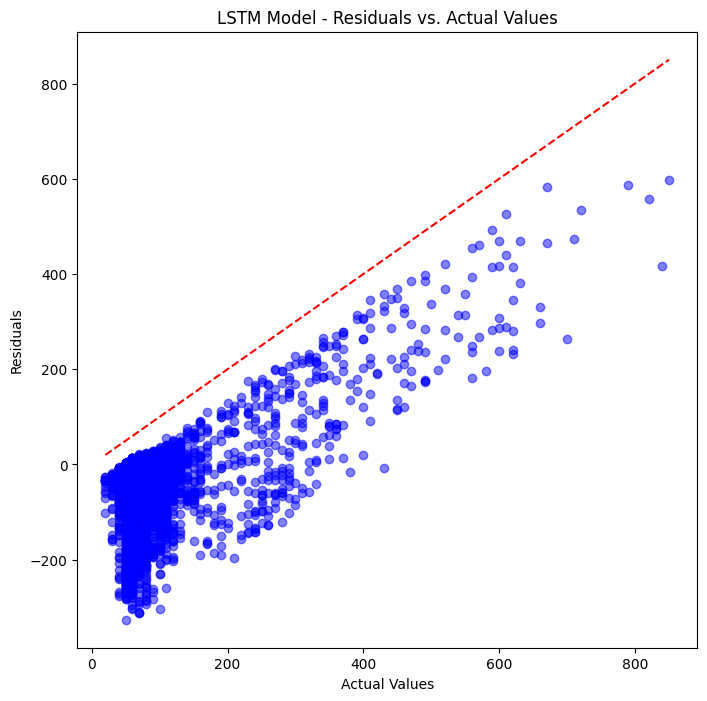

In [ ]:
#Actual vs Residual plot
plot_scatter_actual_vs_predicted(y_test1, lstm_ress, 'Actual Values', 'Residuals', 'LSTM Model')

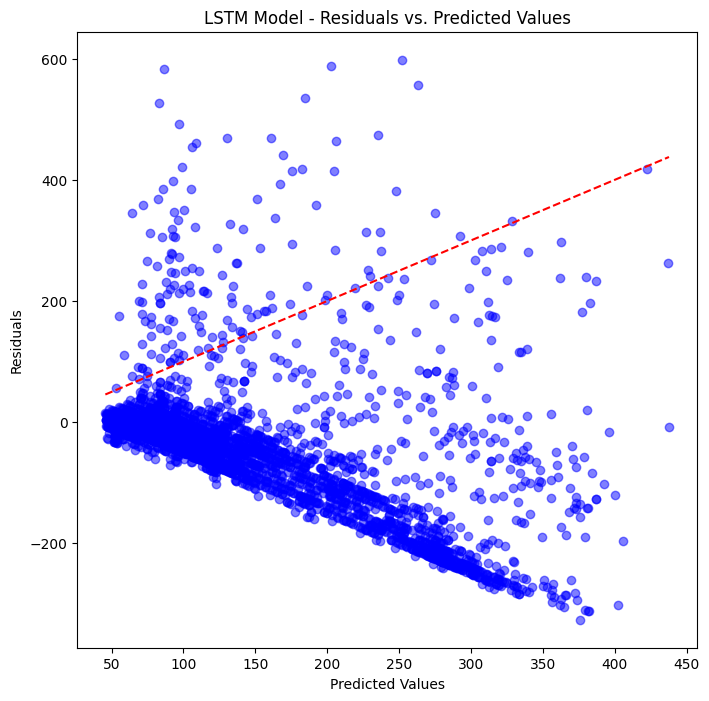

In [ ]:
#Predicted vs Residual plot
plot_scatter_actual_vs_predicted(y_pred_lstm, lstm_ress, 'Predicted Values', 'Residuals', 'LSTM Model')

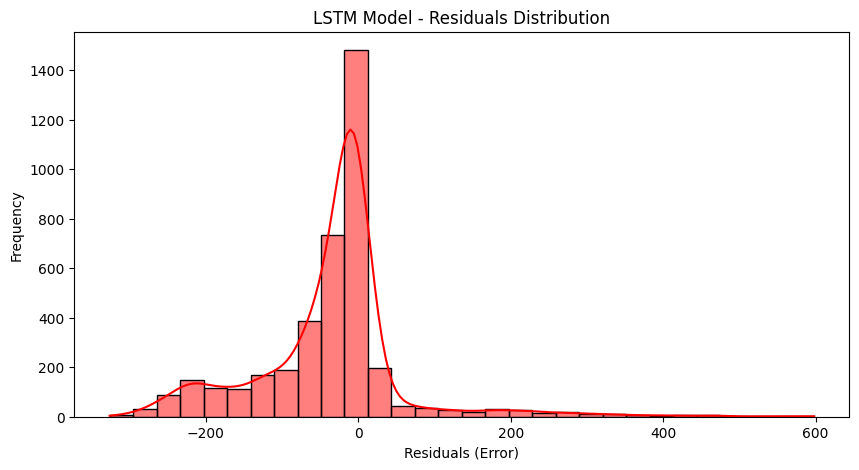

In [ ]:
#Residual plot
plot_residuals(y_test1, y_pred_lstm, 'LSTM Model')

CNN-LSTM MODEL

In [ ]:
#Function for the CNN-LSTM Model
def build_cnn_lstm_model(hp, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters1', 64, 128, step=32), kernel_size=3, activation='relu',
                     padding='same', input_shape=input_shape))
    model.add(Conv1D(filters=hp.Int('filters2', 32, 64, step=32), kernel_size=3, activation='relu', padding='same'))

    model.add(MaxPooling1D(2))

    model.add(LSTM(units=hp.Int('lstm1', 64, 128, step=32), return_sequences=True))
    model.add(Dropout(hp.Float('drop1', 0.2, 0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('lstm2', 32, 64, step=32)))
    model.add(Dropout(hp.Float('drop2', 0.2, 0.5, step=0.1)))

    model.add(Dense(hp.Int('dense_units', 32, 128, step=32), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 5e-4, 1e-4])),
                  loss='mse', metrics=['mae'])
    return model

In [ ]:
# Hyperparameter tuning using RandomSearch
cnnlstm_tuner = RandomSearch(
    lambda hp: build_cnn_lstm_model(hp, input_shape=(X_train.shape[1], X_train.shape[2])),
    objective='val_mae',
    max_trials=3,
    directory='tuning2',
    project_name='energy_cnn_lstm',
    overwrite=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Performing the hyperparameter tuning
cnnlstm_tuner.search(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

Trial 3 Complete [00h 05m 39s]
val_mae: 36.62929153442383

Best val_mae So Far: 33.66735076904297
Total elapsed time: 00h 15m 51s


In [ ]:
#Selecting the best CNN-LSTM parameter
best_cnn_lstm = cnnlstm_tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Trainning the best CNN-LSTM model
cnnlstm_history = best_cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 5375.2241 - mae: 39.3236 - val_loss: 5413.1411 - val_mae: 33.1497
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 5518.5928 - mae: 40.0467 - val_loss: 4682.7900 - val_mae: 31.7006
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 5326.5967 - mae: 39.1791 - val_loss: 4404.2622 - val_mae: 34.6569
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 5072.3774 - mae: 38.1041 - val_loss: 4682.5088 - val_mae: 32.6637
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 5239.8203 - mae: 38.4209 - val_loss: 4726.2568 - val_mae: 36.2536
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 5198.1001 - mae: 37.9570 - val_loss: 4980.6230 - val_mae: 39.1290
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 5264.5200 - mae: 38.1477 - val_loss: 4580.6211 - val_mae: 32.3932
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 4810.7783 - mae: 36.3611 - val_loss: 4160.

In [ ]:
#CNN-LSTM model predictions
y_pred_cnnlstm = best_cnn_lstm.predict(X_test)

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [ ]:
#Inverse transform predictions
#y_pred_cnnlstm = scaler_y.inverse_transform(y_pred_cnnlstm_scaled)

In [ ]:
#Inverse transform y_test
y_test2 = y_test
#scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

In [ ]:
# Evaluation Metrics
cnnlstm_mae = mean_absolute_error(y_test2, y_pred_cnnlstm)
cnnlstm_rmse = np.sqrt(mean_squared_error(y_test2, y_pred_cnnlstm))
cnnlstm_r2 = r2_score(y_test2, y_pred_cnnlstm)
cnnlstm_accuracy = 1 - (cnnlstm_mae / np.mean(y_test2))

In [ ]:
print(f"CNN-LSTM MAE: {cnnlstm_mae:.4f}")
print(f"CNN-LSTM RMSE: {cnnlstm_rmse:.4f}")
print(f"CNN-LSTM R²: {cnnlstm_r2:.4f}")
print(f"CNN-LSTM Accuracy: {cnnlstm_accuracy:.4f}")

CNN-LSTM MAE: 40.5226
CNN-LSTM RMSE: 88.7223
CNN-LSTM R²: 0.0464
CNN-LSTM Accuracy: 0.5782


In [ ]:
#Residuals
cnnlstm_ress = y_test2 - y_pred_cnnlstm.flatten()

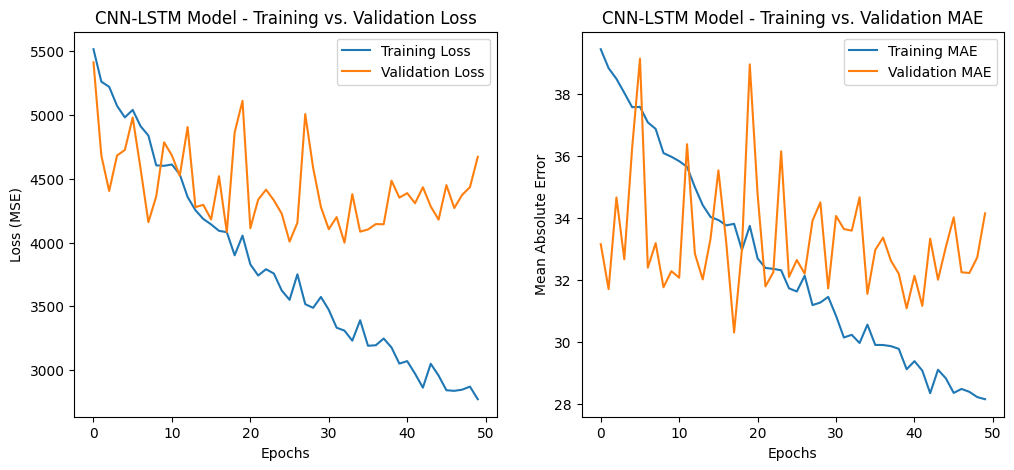

In [ ]:
#CNN-LSTM learning curves
plot_training_history(cnnlstm_history, 'CNN-LSTM Model')

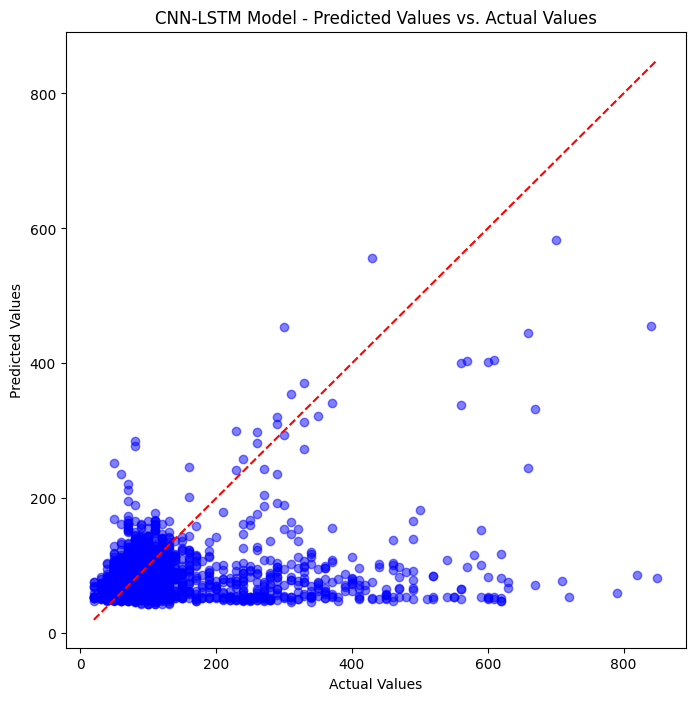

In [ ]:
#CNN-LSTM Scatter plot
plot_scatter_actual_vs_predicted(y_test2, y_pred_cnnlstm, 'Actual Values', 'Predicted Values', 'CNN-LSTM Model')

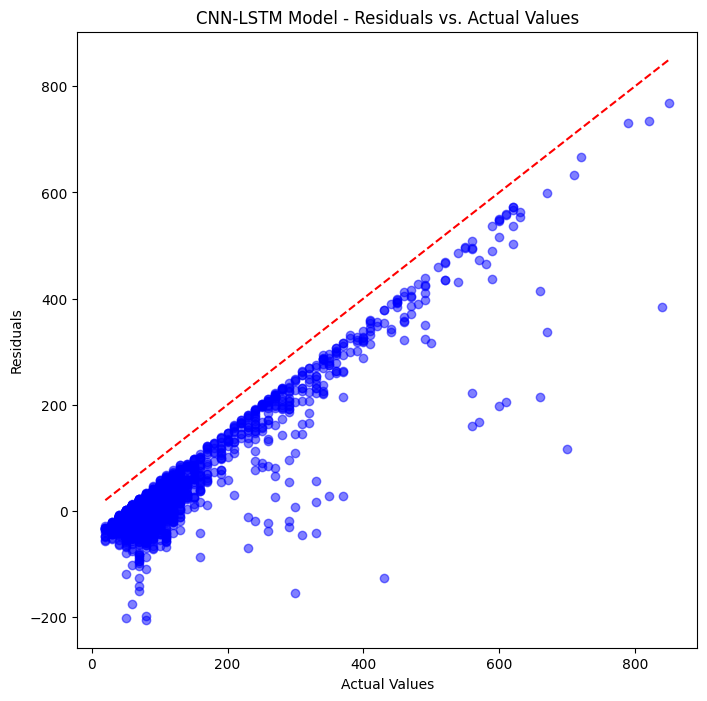

In [ ]:
#Actual vs Residual plot
plot_scatter_actual_vs_predicted(y_test2, cnnlstm_ress, 'Actual Values', 'Residuals','CNN-LSTM Model')

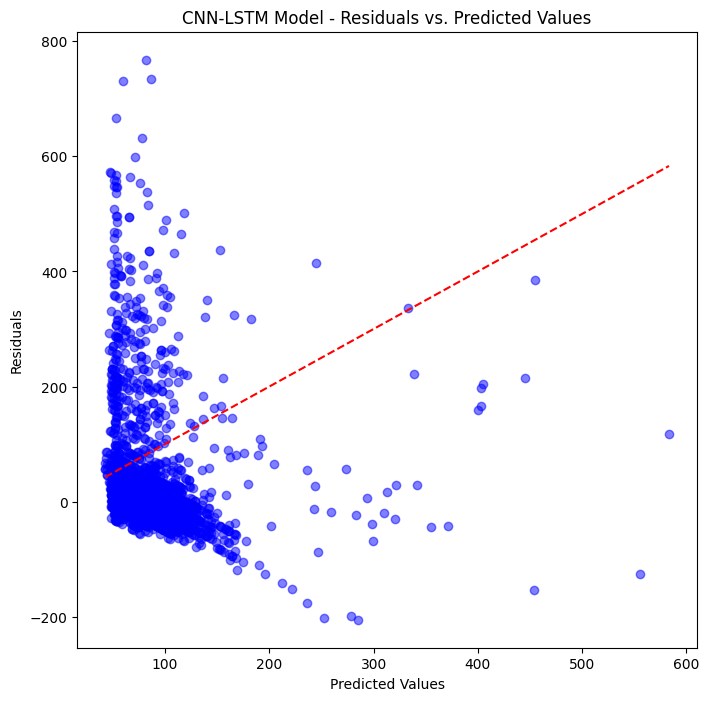

In [ ]:
#Predicted vs Residual plot
plot_scatter_actual_vs_predicted(y_pred_cnnlstm, cnnlstm_ress, 'Predicted Values', 'Residuals','CNN-LSTM Model')

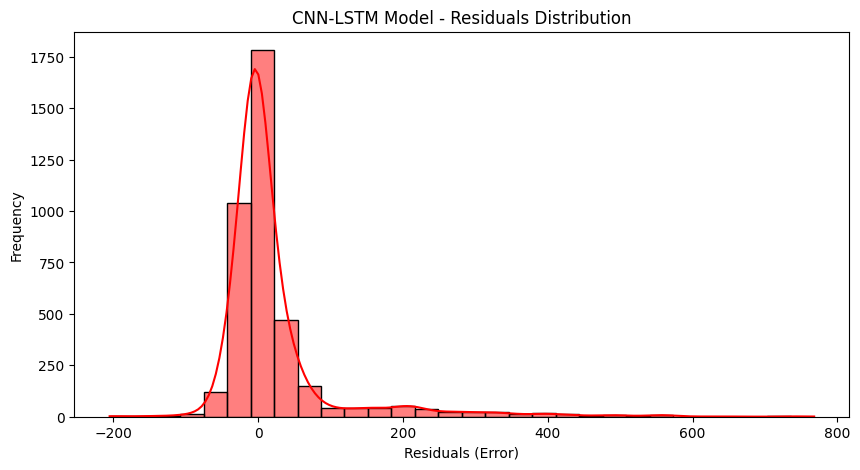

In [ ]:
#Residual plot
plot_residuals(y_test2, y_pred_cnnlstm, 'CNN-LSTM Model')

AUTOENCODER FOR DIMENTIONALITY REDUCTION

In [ ]:
# Function for Encoder
def build_encoder(input_dim, latent_dim=32):
    inputs = Input(shape=(input_dim,))

    # Encoder layers
    encoded = Dense(128, activation='relu')(inputs)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(latent_dim, activation='relu')(encoded)

    return Model(inputs, encoded, name='encoder')

# Function for Decoder
def build_decoder(input_dim, latent_dim=32):
    latent_inputs = Input(shape=(latent_dim,))

    # Decoder layers
    decoded = Dense(64, activation='relu')(latent_inputs)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    return Model(latent_inputs, decoded, name='decoder')


In [ ]:
# The Autoencoder

#Feature dimension and new dimension
input_dim = X_train.shape[2]
latent_dim = 5
window_size = X_train.shape[1]

encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(input_dim, latent_dim)

autoencoder = Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
X_train_flat = X_train.reshape(-1, input_dim)

11813/11813 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


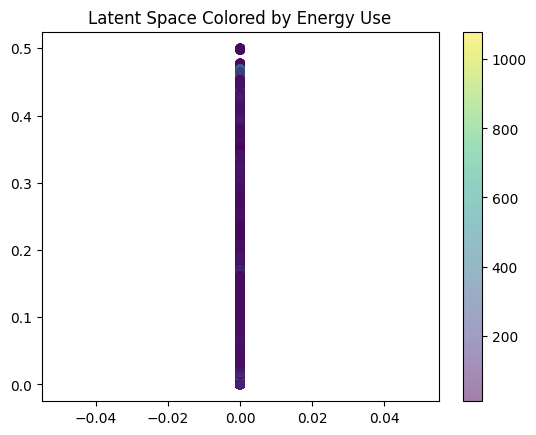

In [ ]:
window_size = 24
latent_reps = encoder.predict(X_train_flat)
# Reshape y_train to match the first dimension of latent_reps
y_train_reshaped = np.repeat(y_train, window_size)
plt.scatter(latent_reps[:, 0], latent_reps[:, 1], c=y_train_reshaped[:latent_reps.shape[0]], alpha=0.5)
plt.colorbar()
plt.title('Latent Space Colored by Energy Use')
plt.show()

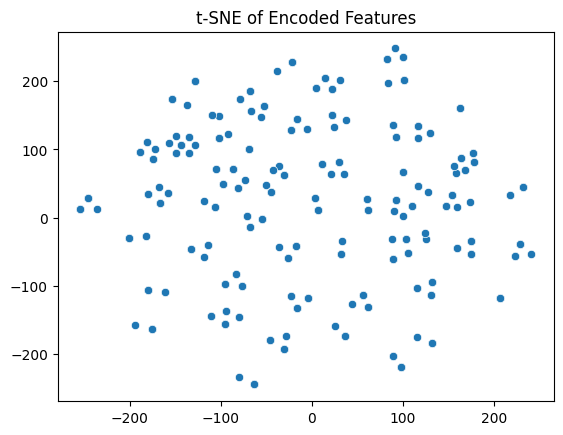

In [ ]:
#Verifying the compression
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=30)
X_vis = tsne.fit_transform(latent_reps[:1000])

sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1])
plt.title("t-SNE of Encoded Features")
plt.show()

In [ ]:
# Train the autoencoder

autoencoder.fit(X_train_flat, X_train_flat, epochs=100, batch_size=64,
                validation_split=0.2, callbacks=[EarlyStopping(patience=10)], verbose=1)

Epoch 1/100
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0250 - val_loss: 0.0151
Epoch 2/100
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0071 - val_loss: 0.0162
Epoch 3/100
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0055 - val_loss: 0.0158
Epoch 4/100
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0047 - val_loss: 0.0173
Epoch 5/100
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0043 - val_loss: 0.0176
Epoch 6/100
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0040 - val_loss: 0.0177
Epoch 7/100
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0037 - val_loss: 0.0184
Epoch 8/100
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0035 - val_loss: 0.0181
Epoch 9/100
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0034 - val_loss: 0.0181
Epoch 10/100
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0032 - val_loss: 0.0192
Epoch 11/100
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0031 - val_loss: 0.0184


In [ ]:
# Compress train and test features
X_train_encoded = encoder.predict(X_train.reshape(-1, input_dim))
X_test_encoded = encoder.predict(X_test.reshape(-1, input_dim))

# Reshape back to sequences
X_train_encod = X_train_encoded.reshape(-1, window_size, latent_dim)
X_test_encod = X_test_encoded.reshape(-1, window_size, latent_dim)

11813/11813 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [ ]:
#Scaler for encoding
scaler_latent = MinMaxScaler()

In [ ]:
# Flatten for scaling
X_train_encoded_flat = X_train_encod.reshape(-1, latent_dim)
X_test_encoded_flat = X_test_encod.reshape(-1, latent_dim)

In [ ]:
# Fit scaler on train, apply to both
X_train_encoded = scaler_latent.fit_transform(X_train_encoded_flat).reshape(-1, window_size, latent_dim)
X_test_encoded = scaler_latent.transform(X_test_encoded_flat).reshape(-1, window_size, latent_dim)

In [ ]:
print(np.min(X_train_encoded), np.max(X_train_encoded))
print(np.min(X_test_encoded), np.max(X_test_encoded))

0.0 1.0
0.0 0.95221496


MODELS TRAINNING WITH COMPRESSED FEATURES

LSTM MODEL

In [ ]:
#Hyperparameter tunning using RandomSearch for the model
encodedlstm_tuner = RandomSearch(
    lambda hp: build_lstm_model(hp, input_shape=(X_train_encoded.shape[1], X_train_encoded.shape[2])),
    objective='val_mae',
    max_trials=3,
    directory='tuning3',
    project_name='energy_encodedlstm',
    overwrite=True )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Performing the hyperparameter tuning
encodedlstm_tuner.search(X_train_encoded, y_train, epochs=20, validation_split=0.2,  verbose=1)

Trial 3 Complete [00h 13m 13s]
val_mae: 45.174896240234375

Best val_mae So Far: 44.45219421386719
Total elapsed time: 00h 35m 47s


In [ ]:
#Selecting the best LSTM parameter
best_encodedlstm = encodedlstm_tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Training the best LSTM model
encodedlstm_history = best_encodedlstm.fit(X_train_encoded, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - loss: 10152.1426 - mae: 56.8757 - val_loss: 8703.0684 - val_mae: 56.6887
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - loss: 10178.2334 - mae: 58.8850 - val_loss: 8571.8076 - val_mae: 53.1101
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - loss: 10294.6455 - mae: 58.5994 - val_loss: 8507.6602 - val_mae: 49.4733
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - loss: 9720.9072 - mae: 57.5844 - val_loss: 8605.6514 - val_mae: 54.0940
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - loss: 10524.0947 - mae: 59.8303 - val_loss: 8509.1406 - val_mae: 48.7651
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - loss: 9629.2021 - mae: 56.4106 - val_loss: 8497.3525 - val_mae: 51.9029
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - loss: 9962.5010 - mae: 57.4559 - val_loss: 8554.2910 - val_mae: 54.8323
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - loss: 10259.0352 - mae: 59.1720 - val_loss: 

In [ ]:
#Predictions for LSTM model
y_pred_encodedlstm = best_encodedlstm.predict(X_test_encoded)

124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


In [ ]:
#Inverse transform predictions
#y_pred_encodedlstm = scaler_y.inverse_transform(y_pred_encodedlstm_scaled)

In [ ]:
#Inverse transform y_test
y_test3 = y_test
#scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

In [ ]:
# Evaluation Metrics
encodedlstm_mae = mean_absolute_error(y_test3, y_pred_encodedlstm)
encodedlstm_rmse = np.sqrt(mean_squared_error(y_test3, y_pred_encodedlstm))
encodedlstm_r2 = r2_score(y_test3, y_pred_encodedlstm)
encodedlstm_accuracy = 1 - (encodedlstm_mae / np.mean(y_test3))

In [ ]:
print(f"ENC-LSTM MAE: {encodedlstm_mae:.4f}")
print(f"ENC-LSTM RMSE: {encodedlstm_rmse:.4f}")
print(f"ENC-LSTM R²: {encodedlstm_r2:.4f}")
print(f"ENC-LSTM Accuracy: {encodedlstm_accuracy:.4f}")

ENC-LSTM MAE: 59.6431
ENC-LSTM RMSE: 93.9188
ENC-LSTM R²: -0.0686
ENC-LSTM Accuracy: 0.3792


In [ ]:
#Residual
encodedlstm_ress = y_test3 - y_pred_encodedlstm.flatten()

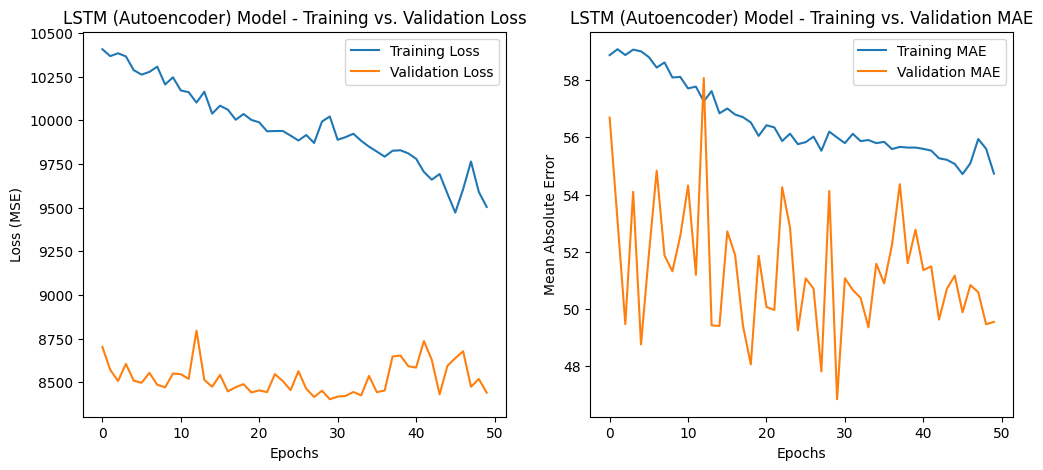

In [ ]:
#LSTM learning curves
plot_training_history(encodedlstm_history, 'LSTM (Autoencoder) Model')

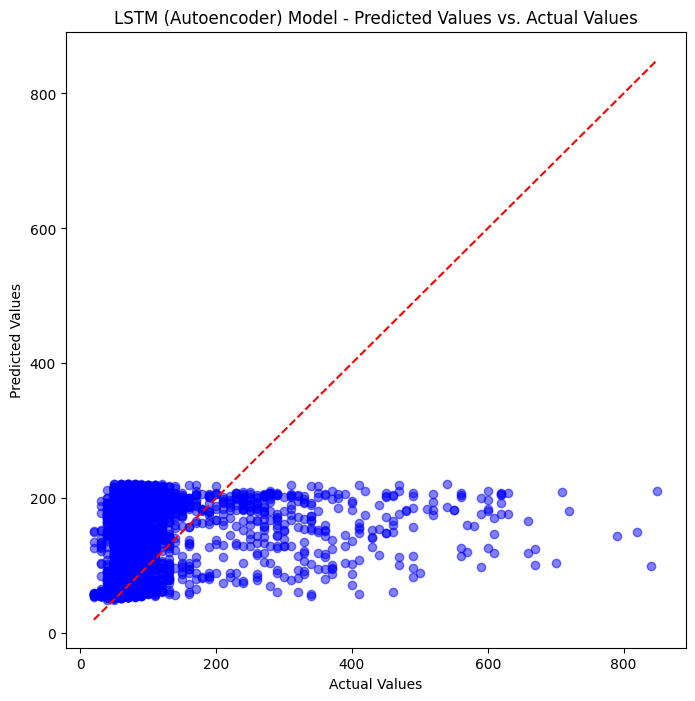

In [ ]:
#LSTM Scatter plot
plot_scatter_actual_vs_predicted(y_test3, y_pred_encodedlstm, 'Actual Values', 'Predicted Values', 'LSTM (Autoencoder) Model')

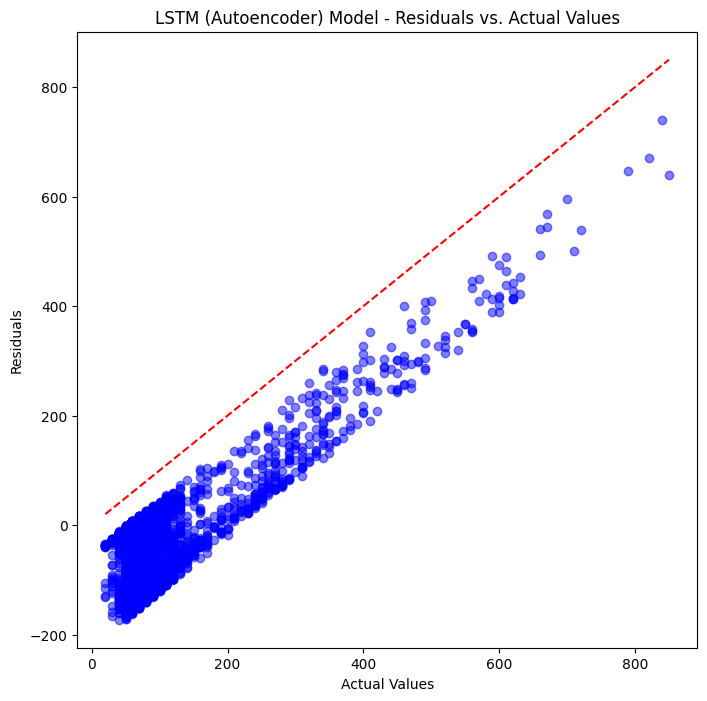

In [ ]:
#Actual vs Residual plot
plot_scatter_actual_vs_predicted(y_test3, encodedlstm_ress, 'Actual Values', 'Residuals', 'LSTM (Autoencoder) Model')

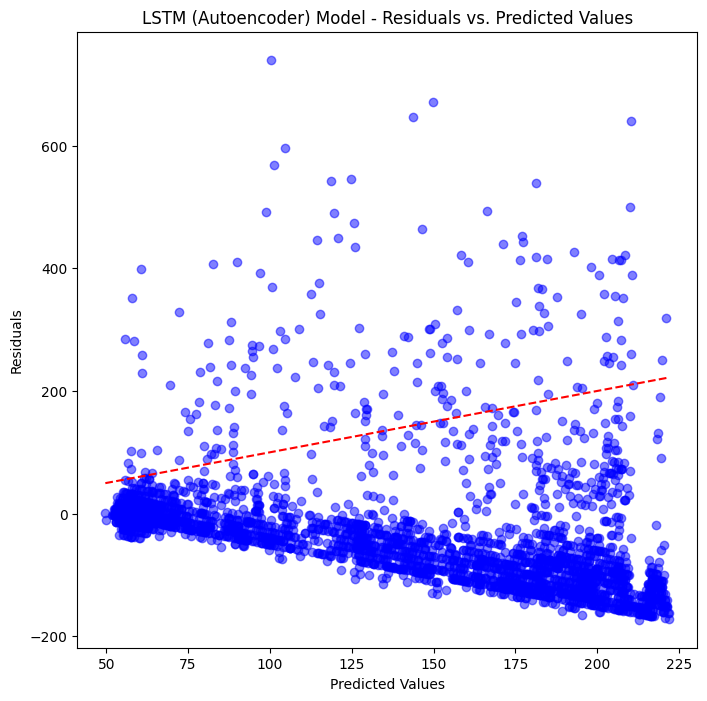

In [ ]:
#Predicted vs Residual plot
plot_scatter_actual_vs_predicted(y_pred_encodedlstm, encodedlstm_ress, 'Predicted Values', 'Residuals', 'LSTM (Autoencoder) Model')

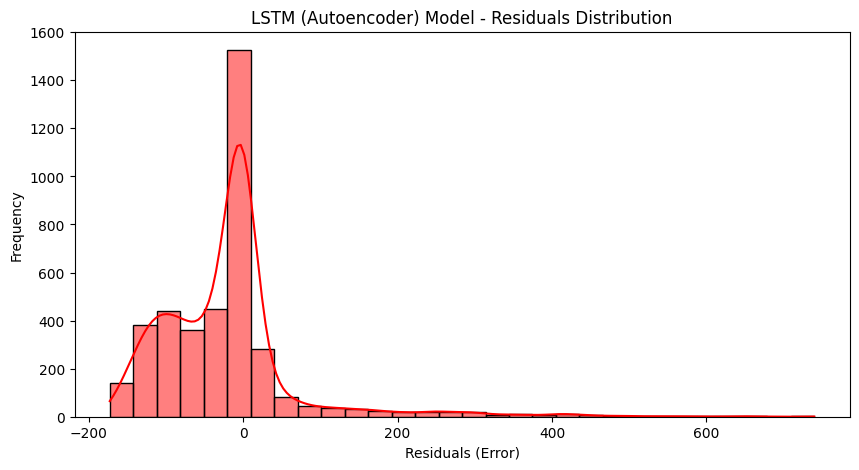

In [ ]:
#Residual plot
plot_residuals(y_test3, y_pred_encodedlstm, 'LSTM (Autoencoder) Model')

CNN-LSTM MODEL

In [ ]:
# Hyperparameter tuning using RandomSearch
encodedcnnlstm_tuner = RandomSearch(
    lambda hp: build_lstm_model(hp, input_shape=(X_train_encoded.shape[1], X_train_encoded.shape[2])),
    objective='val_mae',
    max_trials=3,
    directory='tuning4',
    project_name='energy_encodedcnn_lstm',
    overwrite=True )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Performing the hyperparameter tuning
encodedcnnlstm_tuner.search(X_train_encoded, y_train, epochs=20, validation_split=0.2, verbose=1)

Trial 3 Complete [00h 06m 52s]
val_mae: 45.51800537109375

Best val_mae So Far: 45.51800537109375
Total elapsed time: 00h 20m 12s


In [ ]:
#Selecting the best CNN-LSTM parameter
best_encodedcnn_lstm = encodedcnnlstm_tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Trainning the best CNN-LSTM model
encodedcnnlstm_history = best_encodedcnn_lstm.fit(X_train_encoded, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - loss: 10970.0820 - mae: 56.3104 - val_loss: 8611.9883 - val_mae: 50.8513
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - loss: 10452.2568 - mae: 58.2575 - val_loss: 8485.5361 - val_mae: 50.5077
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - loss: 9826.3760 - mae: 55.2533 - val_loss: 8541.1660 - val_mae: 52.4882
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 9853.1787 - mae: 55.2260 - val_loss: 8395.4082 - val_mae: 49.5436
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 9897.4336 - mae: 54.5060 - val_loss: 8568.3896 - val_mae: 55.0655
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - loss: 9797.4541 - mae: 56.1987 - val_loss: 8509.5469 - val_mae: 51.6987
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 9539.0059 - mae: 54.5867 - val_loss: 8839.6904 - val_mae: 57.8353
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - loss: 10119.5283 - mae: 56.2869 - val_loss: 84

In [ ]:
#CNN-LSTM model predictions
y_pred_encodedcnnlstm = best_encodedcnn_lstm.predict(X_test_encoded)

124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


In [ ]:
#Inverse transform predictions
#y_pred_encodedcnnlstm = scaler_y.inverse_transform(y_pred_encodedcnnlstm_scaled)

In [ ]:
#Inverse transform y_test
y_test4 = y_test
#scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

In [ ]:
# Evaluation Metrics
encodedcnnlstm_mae = mean_absolute_error(y_test4, y_pred_encodedcnnlstm)
encodedcnnlstm_rmse = np.sqrt(mean_squared_error(y_test4, y_pred_encodedcnnlstm))
encodedcnnlstm_r2 = r2_score(y_test4, y_pred_encodedcnnlstm)
encodedcnnlstm_accuracy = 1 - (encodedcnnlstm_mae / np.mean(y_test4))

In [ ]:
print(f"ENC CNN-LSTM MAE: {encodedcnnlstm_mae:.4f}")
print(f"ENC CNN-LSTM RMSE: {encodedcnnlstm_rmse:.4f}")
print(f"ENC CNN-LSTM R²: {encodedcnnlstm_r2:.4f}")
print(f"ENC CNN-LSTM Accuracy: {encodedcnnlstm_accuracy:.4f}")

ENC CNN-LSTM MAE: 87.3504
ENC CNN-LSTM RMSE: 132.4946
ENC CNN-LSTM R²: -1.1267
ENC CNN-LSTM Accuracy: 0.0908


In [ ]:
#Residual
encodedcnnlstm_ress = y_test4 - y_pred_encodedcnnlstm.flatten()

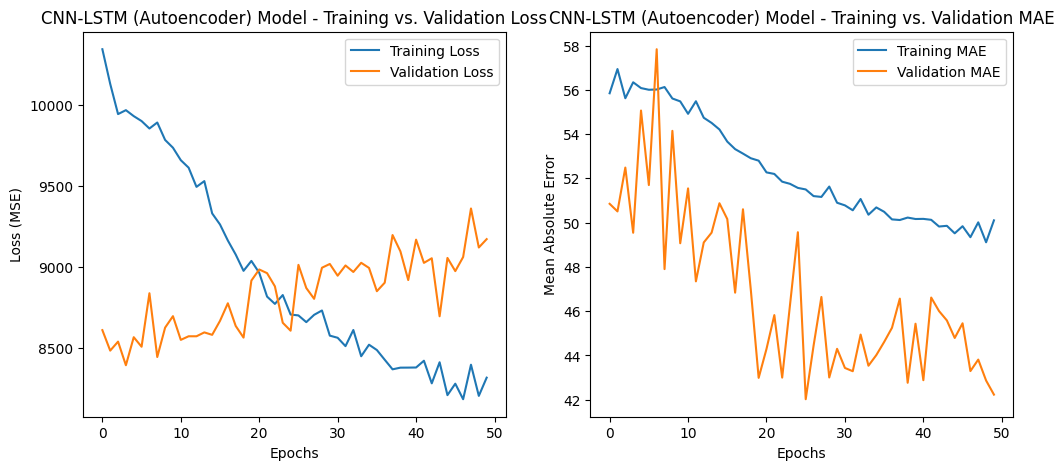

In [ ]:
#CNN-LSTM learning curves
plot_training_history(encodedcnnlstm_history, 'CNN-LSTM (Autoencoder) Model')

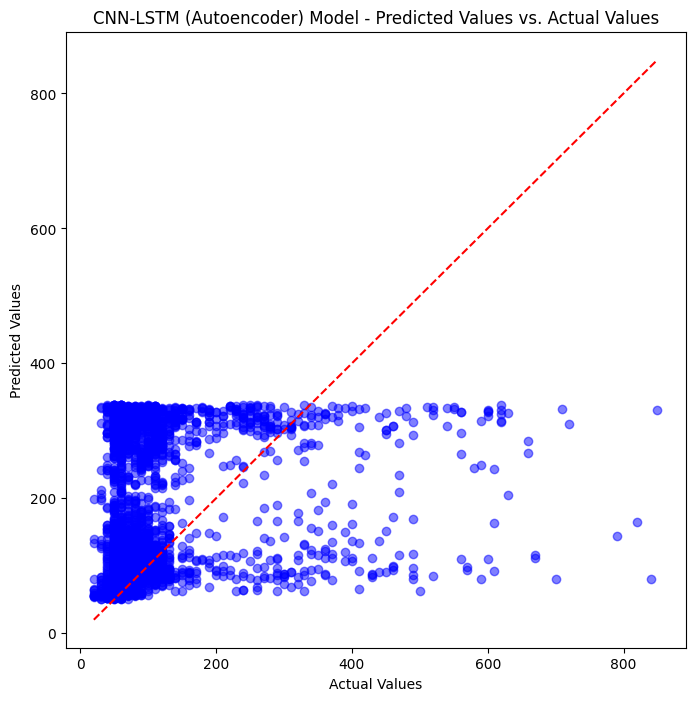

In [ ]:
#CNN-LSTM Scatter plot
plot_scatter_actual_vs_predicted(y_test4, y_pred_encodedcnnlstm, 'Actual Values', 'Predicted Values', 'CNN-LSTM (Autoencoder) Model')

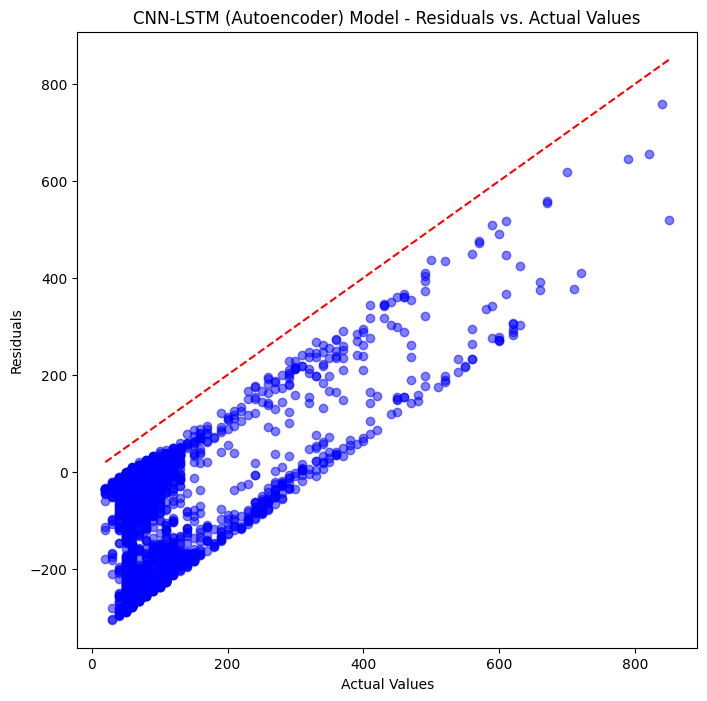

In [ ]:
#Actual vs Residual
plot_scatter_actual_vs_predicted(y_test4, encodedcnnlstm_ress, 'Actual Values', 'Residuals', 'CNN-LSTM (Autoencoder) Model')

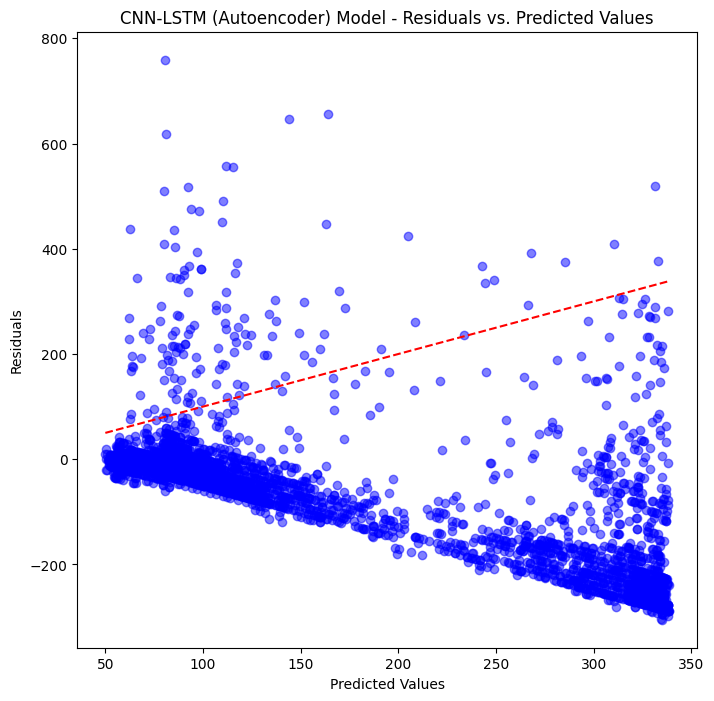

In [ ]:
#Predicted vs Residual
plot_scatter_actual_vs_predicted(y_pred_encodedcnnlstm, encodedcnnlstm_ress, 'Predicted Values', 'Residuals', 'CNN-LSTM (Autoencoder) Model')

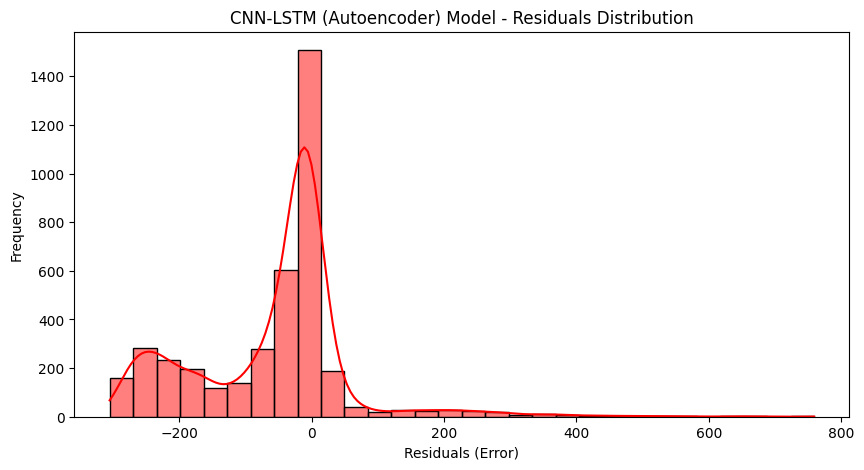

In [ ]:
#Residual plot
plot_residuals(y_test4, y_pred_encodedcnnlstm, 'CNN-LSTM (Autoencoder) Model')